# Imports and configs

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


In [2]:
airline_passengers_data_path = "https://storage.googleapis.com/edulabs-public-datasets/airline-passengers.csv"
shampoo_sales_data_path = "https://storage.googleapis.com/edulabs-public-datasets/shampoo-sales.csv"

#This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
dayly_minimum_temp_data_path = "https://storage.googleapis.com/edulabs-public-datasets/daily-minimum-temperatures.csv"

# number of daily female births in California in 1959
dayly_total_female_births_data_path = "https://storage.googleapis.com/edulabs-public-datasets/daily-total-female-births.csv"

In [17]:
pd.options.plotting.backend = "matplotlib"


# Load Data

In [6]:
airline_df = pd.read_csv(airline_passengers_data_path, parse_dates=["Month"])
from datetime import datetime
def parser(x):
    return datetime.strptime('199'+x, '%Y-%m')
sales_df = pd.read_csv(shampoo_sales_data_path, parse_dates=['Month'], date_parser=parser, index_col='Month')
births_df = pd.read_csv(dayly_total_female_births_data_path, parse_dates=["Date"])
temp_df = pd.read_csv(dayly_minimum_temp_data_path, parse_dates=["Date"])


<ipython-input-6-39f33bb9c9d5>:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sales_df = pd.read_csv(shampoo_sales_data_path, parse_dates=['Month'], date_parser=parser, index_col='Month')


In [7]:
ts = temp_df.set_index('Date').squeeze()

#Visualize the Series

In [8]:
ts.plot()

# Check for Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts)
print(f'p-value: {result[1]}')

p-value: 0.0002470826300360994


Stationary!

# Difference the Series (if needed)

- Apply differencing until stationarity is achieved
- Repeat if needed: ts.diff(2), etc.
- Set d = number of differences used

In [ ]:
# no need here - already stationary!

# Plot ACF and PACF to determine q and p

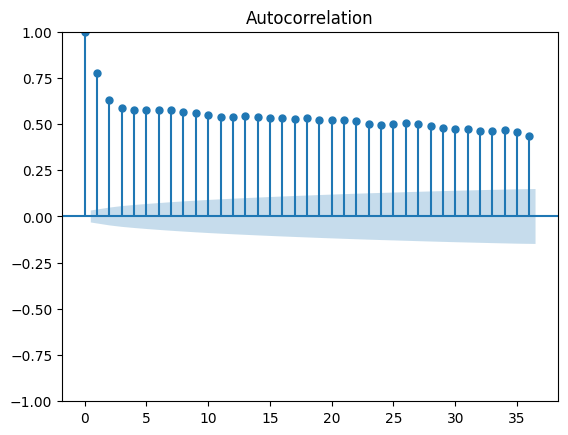

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts)

plt.show()

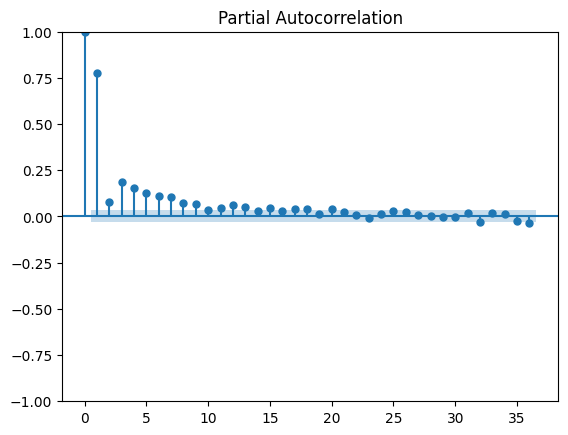

In [12]:
plot_pacf(ts)
plt.show()

# Select (p, d, q)
- Use ACF → suggest 𝑞
- Use PACF → suggest 𝑝
- Use differencing step → gives 𝑑

In [13]:
p = 7
q = 2
d = 0

# Fit the ARIMA Model

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts, order=(p, d, q))
result = model.fit()
print(result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 3650
Model:                 ARIMA(7, 0, 2)   Log Likelihood               -8382.640
Date:                Sun, 04 May 2025   AIC                          16787.279
Time:                        15:00:29   BIC                          16855.507
Sample:                             0   HQIC                         16811.577
                               - 3650                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4801      0.795     14.449      0.000       9.923      13.037
ar.L1          0.5280      0.205      2.570      0.010       0.125       0.931
ar.L2          0.7950      0.306      2.601      0.0

# Check Residuals

Residuals should be white noise

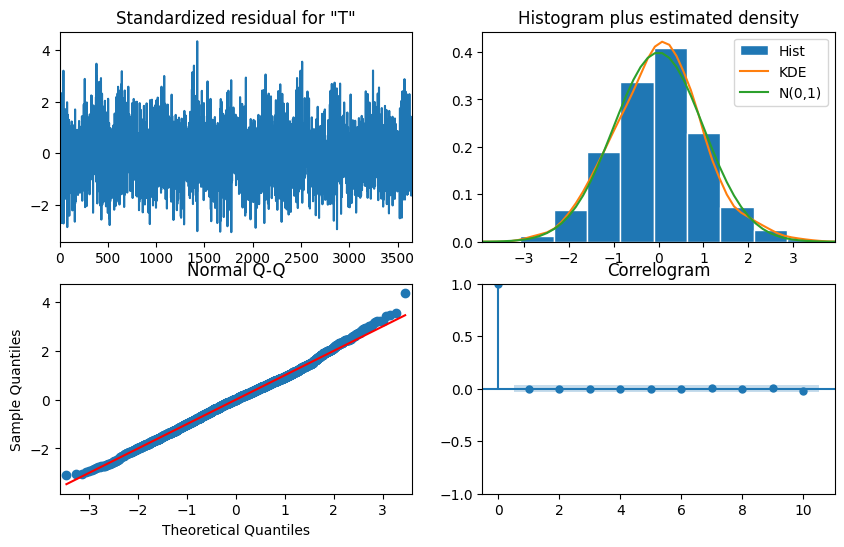

In [20]:
result.plot_diagnostics(figsize=(10, 6))
plt.show()

# Using ARIMA with TimeSeries CV

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


# Define model order (for ARIMA)
p, d, q = 7, 0, 2

# Setup time series split (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
errors = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(ts)):
    train, test = ts.iloc[train_idx], ts.iloc[test_idx]

    # Fit ARIMA on training data
    try:
        model = ARIMA(train, order=(p, d, q))
        result = model.fit()

        # Forecast the length of the test set
        forecast = result.forecast(steps=len(test))

        # Evaluate forecast
        mse = mean_squared_error(test, forecast)
        errors.append(mse)
        print(f"Fold {fold + 1}: MSE = {mse:.4f}")
    except:
        print(f"Fold {fold + 1}: model failed")
        continue

print(f"\nAverage MSE across folds: {np.mean(errors):.4f}")


# ARIMA Grid Search

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")



# Candidate parameters
p_values = [2, 7]
d_values = [0]
q_values = [1, 2]

# CV Setup
tscv = TimeSeriesSplit(n_splits=5)

# Search
best_score = float("inf")
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            mse_list = []
            for train_idx, test_idx in tscv.split(ts):
                train, test = ts.iloc[train_idx], ts.iloc[test_idx]
                try:
                    model = ARIMA(train, order=(p, d, q)).fit()
                    forecast = model.forecast(steps=len(test))
                    mse = mean_squared_error(test, forecast)
                    mse_list.append(mse)
                except:
                    break  # Skip failed models
            if len(mse_list) == tscv.get_n_splits():
                avg_mse = np.mean(mse_list)
                print(f"ARIMA({p},{d},{q}) MSE = {avg_mse:.3f}")
                if avg_mse < best_score:
                    best_score = avg_mse
                    best_order = (p, d, q)

print(f"\n✅ Best order: ARIMA{best_order} with average MSE = {best_score:.3f}")


ARIMA(2,0,1) MSE = 16.383
ARIMA(2,0,2) MSE = 16.723
ARIMA(7,0,1) MSE = 16.547
ARIMA(7,0,2) MSE = 17.123

✅ Best order: ARIMA(2, 0, 1) with average MSE = 16.383


# SARIMA (seasonal ARIMA)

p,d,q = non-seasonal ARIMA orders
P,D,Q = seasonal ARIMA orders
s = seasonal period (e.g., 12 for monthly data with yearly cycle, 7 for weekly seasonality on daily data)

In [26]:
ts = airline_df.set_index('Month').squeeze()

<Axes: xlabel='Month'>

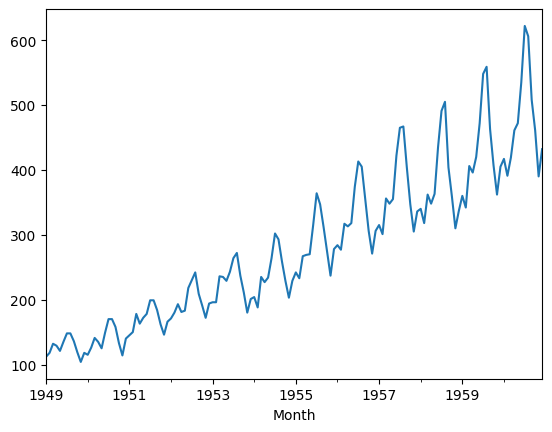

In [27]:
ts.plot()

## Exercise

Find appropriate parameters for SARIMA and fit the model

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX


# model = SARIMAX(ts, order=(p,d,q), seasonal_order=(P,D,Q,s))
# result = model.fit()
# result.summary()


# Auto ARIMA